In [ ]:
# default_exp datastruct.core

In [ ]:
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_1612596/2943078347.py:2: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Sequence Data Structure </center></h1>

This module is highly inspired from this [`fastai` tutorial](https://docs.fast.ai/tutorial.siamese.html) and [Chapter 11 of the `fastbook`](https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb).

Let's start by loading the data we will use in the examples:

In [ ]:
# export

import os
import pickle
import warnings
from pathlib import Path
from random import random, sample
from typing import List, Tuple

import numpy as np
import pandas as pd
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.xtras import load_pickle, save_pickle
from progressbar import progressbar

from footSeq.plots import plot_actions

SeqenceData = dict[str, pd.DataFrame]
TargetData = dict[str, str]
FilesPath = List[Path]
Tfms = List[Transform]

In [ ]:
data_path = Path("/sequences")
metadata_path = Path("./data")
files_list_path = metadata_path / "file_list.pkl"
if os.path.isfile(files_list_path):
    all_files = load_pickle(files_list_path)
else:
    all_files = data_path.ls(file_exts=".csv")

In [ ]:
files = all_files[:100000]

# Data transform

In order to prepare our data in batches, we will need to transform our data from `SPADL` like sequence of play to time-series like tensor accepted by `fastai` or `tsai`. The appropriate way to do this in `fastai` is to define a custom `Transform`. That's what the `FootTransform` is about.

However, before we get there we need to define some utility functions to deal with the raw files.

## Files parsing

The first function parses the file name and extracts the relevant info:

In [ ]:
# export


def parse_file_info(file_path, sep="___") -> pd.DataFrame:
    "Parse file information from file-name"
    game_id, poss_nbr, start_id, end_id, target = file_path.stem.split(sep)
    _id = game_id + "_" + start_id + "-" + end_id
    dico = {
        "id": _id,
        "gameId": int(game_id),
        "possNumber": int(poss_nbr),
        "startId": float(start_id),
        "endId": float(end_id),
        "target": target,
        "file": file_path,
        "nSteps": pd.read_csv(file_path).shape[0],
    }
    return pd.DataFrame(dico, index=[0])

The number of files can become huge (several millions) and hence we will need to select files randomly as we won't be able to use them all. Besides, due to the huge unbalanced nature of our data-set, we will need to randomly pick a proportion on non-goal examples. The function pick files will loop only once over the list of files and produces a `dataFrame` with relevant info:  

In [ ]:
# export


def pick_files(
    files: FilesPath, goal_prop=0.95, no_goal_prop=0.05, sep="___"
) -> pd.DataFrame:
    """
    Loops over all files and select some for training  and leave the rest for testing

    Parameters
    ----------
    files: List[Path]
        list of all files path available
    goal_prop, no_goal_prop: float in [0, 1]
        proportion of goal and no-goal files to keep

    Returns
    -------
    dict:
        Dictionary with 3 keys:
            - `train_goals`: pd.DataFrame giving training files info with `goal` target
            - `test_goals`: pd.DataFrame giving test files info with `goal` target
            - `no_goals`: selection of files with `no-goal` target

    """
    train_goals = []
    test_goals = []
    no_goals = []

    for _file in progressbar(files):
        _, _, _, _, _target = _file.stem.split(sep)
        _random_toss = random.random()
        if _target == "goal":
            _file_info = parse_file_info(_file, sep)
            if _random_toss < goal_prop:
                train_goals.append(_file_info)
            else:
                test_goals.append(_file_info)
        else:
            if _random_toss < no_goal_prop:
                no_goals.append(parse_file_info(_file, sep))

    return (
        pd.concat(train_goals, axis=0).convert_dtypes().reset_index(drop=True),
        pd.concat(test_goals, axis=0).convert_dtypes().reset_index(drop=True),
        pd.concat(no_goals, axis=0).convert_dtypes().reset_index(drop=True),
    )

In [ ]:
no_goal_prop = 1.5
train_goals, test_goals, no_goals = pick_files(files)

100% (100000 of 100000) |################| Elapsed Time: 0:00:34 Time:  0:00:34


In [ ]:
## training files
n_no_goals_train = int(train_goals.shape[0] * no_goal_prop)
files_info = pd.concat([train_goals, no_goals.sample(n_no_goals_train)], axis=0).sample(
    frac=1, ignore_index=True
)

## test files
n_no_goals_test = int(test_goals.shape[0] * no_goal_prop)
no_goals_left = no_goals[~no_goals.file.isin(files_info.file)].sample(n_no_goals_test)
test_files_info = pd.concat([test_goals, no_goals_left], axis=0).sample(
    frac=1, ignore_index=True
)

labels = L(files_info.target.tolist()).unique(sort=True)
files_info

,id,gameId,possNumber,startId,endId,target,file,nSteps
0,1235375_10488-10501,1235375,42,10488,10501.0,no-goal,/sequences/1235375___42___10488___10501___no-goal.csv,14
1,1244254_25025-25028,1244254,1,25025,25028.0,goal,/sequences/1244254___1___25025___25028___goal.csv,3
2,1484635_5099-5121,1484635,1,5099,5121.0,no-goal,/sequences/1484635___1___5099___5121___no-goal.csv,23
3,1237294_11099-11115,1237294,120,11099,11115.0,no-goal,/sequences/1237294___120___11099___11115___no-goal.csv,17
4,1207546_20435-20445,1207546,202,20435,20445.0,goal,/sequences/1207546___202___20435___20445___goal.csv,10
...,...,...,...,...,...,...,...,...
3732,1468377_10224-10240,1468377,25,10224,10240.0,no-goal,/sequences/1468377___25___10224___10240___no-goal.csv,15
3733,1171523_15161-15178,1171523,142,15161,15178.0,no-goal,/sequences/1171523___142___15161___15178___no-goal.csv,18
3734,1493989_25001-25003,1493989,115,25001,25003.0,no-goal,/sequences/1493989___115___25001___25003___no-goal.csv,3
3735,1172269_12296-12312,1172269,324,12296,12312.0,no-goal,/sequences/1172269___324___12296___12312___no-goal.csv,16


The next step is to define a function that reads a sequence of play. It takes care in particular of fixing NAs when they happen:

In [ ]:
# export


def read_sequence_play(file):
    "Read a sequence of Playing"
    df = pd.read_csv(file)
    ## add a unique key to identify the events
    df["key"] = (
        df["_id"].str.split("___").map(lambda x: x[0])
        + "_"
        + df["event_id"].astype("str")
    )

    ## remove rows with NA on key columns + replace NA on other columns
    df = (
        df.filter(regex="^((?!opponent_).)*$")
        .dropna(
            subset=[
                "team_id",
                "generic_action_type_name",
                "action_subtype_name",
                "type_name",
                "result_name",
                "attack_team_id",
                "is_poss_team",
                "is_att_team",
                "start_x",
                "start_y",
                "standart_name",
                "possession_name",
                "attack_status_name",
                "attack_type_name",
                "under_pressure",
                "high_speed",
                "body_name",
                "touches",
                "shot_type",
                "shot_handling",
            ]
        )
        .fillna({"possession_name": "Undefined"})
    )

    return df


def get_sequence_len(file):
    return read_sequence_play(file).shape[0]

In [ ]:
read_sequence_play(files[10])

,event_id,player_id,player_name,team_id,team_name,period_id,time_seconds,standart_name,possession_name,possession_team_id,...,touches,shot_type,shot_handling,result_id,result_name,seconds_since_poss,is_poss_team,is_att_team,_id,key
0,5741,25491,Maximilian Arnold,134,VfL Wolfsburg,1,1588.82,Direct free kick,Start,134,...,Unknown,Undefined,Undefined,0,fail,0.00,True,True,1493116___79___5741___5743___no-goal,1493116_5741
1,5742,268976,Kingsley Ehizibue,301,1. FC Koln,1,1589.99,Open play,Ball possession,134,...,Unknown,Undefined,Undefined,1,success,1.17,False,False,1493116___79___5741___5743___no-goal,1493116_5742
2,5743,259109,William de Asevedo Furtado,134,VfL Wolfsburg,1,1593.41,Open play,Ball possession,134,...,Unknown,Undefined,Undefined,1,success,4.59,True,True,1493116___79___5741___5743___no-goal,1493116_5743


Finally, we show here how to split the data based on the goal/no-goal distribution:

In [ ]:
# export


def goal_splitter(
    files_info_df: pd.DataFrame,
    no_goal_prop: float = 1.5,
    valid_pct: float = 0.2,
    seed=None,
):
    "Create function that splits `files` between train/valid with `valid_pct` randomly"
    ## get goal indices
    goal_indices = L(files_info_df[files_info_df.target == "goal"].index.tolist())
    all_no_goal_indices = L(
        files_info_df[files_info_df.target != "goal"].index.tolist()
    )
    no_goal_indices = sample(all_no_goal_indices, int(len(goal_indices) * no_goal_prop))

    # now create validation index
    n_sample_goals = int(valid_pct * len(goal_indices))
    n_sample_no_goals = int(valid_pct * len(no_goal_indices))

    val_idx_goals = np.random.choice(
        goal_indices, size=n_sample_goals, replace=False
    ).tolist()
    val_idx_no_goals = np.random.choice(
        no_goal_indices, size=n_sample_no_goals, replace=False
    ).tolist()

    # compute the left indices
    train_goal_idx = [idx for idx in goal_indices if not idx in val_idx_goals]
    train_no_goal_idx = [idx for idx in no_goal_indices if not idx in val_idx_no_goals]

    return (
        L(train_goal_idx + train_no_goal_idx).unique().shuffle(),
        L(val_idx_goals + val_idx_no_goals).unique().shuffle(),
    )

In [ ]:
val_pct = 0.3
train_val_files = L(files_info.file.tolist())
train_idx, val_idx = goal_splitter(
    files_info_df=files_info, no_goal_prop=no_goal_prop, valid_pct=val_pct, seed=43
)
test_eq(len(list(set(train_idx) & set(val_idx))), 0)
test_close(val_pct, len(val_idx) / (len(train_idx) + len(val_idx)), 1e-2)

train_stats = files_info.iloc[train_idx].groupby("target").size()
test_close(no_goal_prop, train_stats["no-goal"] / train_stats["goal"], 1e-2)

## Custom data types

Before we define our custom `Transform`s, we will need a custom type that knows how to `show()` itself. Here we will take advantage of the the functions defined in the `plots` module:

In [ ]:
# export


def _nice_time(row) -> str:
    minute = int((row.period_id - 1) * 45 + row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"


class FootSeqTuple(fastuple):
    def show(self, ctx=None, title=None, **kwargs):
        play_sequence, target = self
        ## remove na
        play_sequence.dropna(inplace=True)
        ## reduce size
        play_sequence = play_sequence.tail(10).copy()
        play_sequence["nice_time"] = play_sequence.apply(_nice_time, axis=1)
        labels = play_sequence[
            [
                "nice_time",
                "type_name",
                "player_name",
                "team_id",
                "result_name",
                "possession_name",
                "attack_type_name",
                "event_id",
            ]
        ]

        ctx = plot_actions(
            location=play_sequence[["start_x", "start_y", "end_x", "end_y"]],
            action_type=play_sequence.type_name,
            team=play_sequence.team_id,
            result=play_sequence.result_name,
            label=labels,
            labeltitle=[
                "time",
                "action",
                "player",
                "teamId",
                "result",
                "possession_type",
                "attack_type",
                "event_id",
            ],
            zoom=False,
            ax=ctx,
            return_fig=False,
            **kwargs,
        )
        if title is None:
            title = target
        ctx.set_title(title)

        return ctx

<AxesSubplot:title={'center':'goal'}>

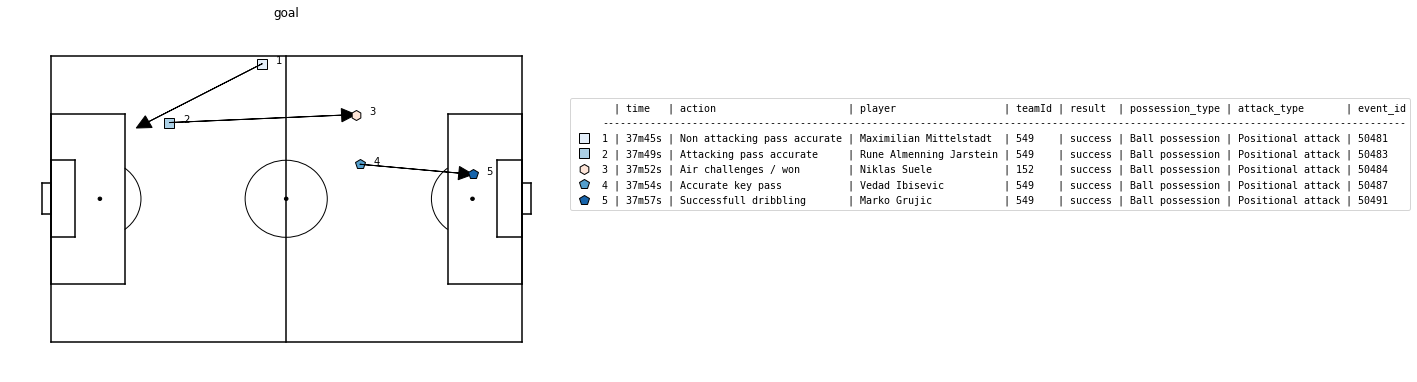

In [ ]:
file_name = files_info[files_info.target == "goal"].sample(1)["file"].values[0]
play_seq = pd.read_csv(file_name).tail(10)
tgt = parse_file_info(file_name)["target"].values[0]

s = FootSeqTuple((play_seq.copy(), tgt))
s.show(figsize=10)

## `Transform`s

For this task, we will define 2 transforms:
+ The first one, `FootSeqTransform` takes care of converting our raw sequence of play to a processed sequence. It is heavily based on `TabularPandas` and will take care of normalizing numerical features, categorize categorical features and fill in gaps eventually
+ The second `Transform` `FootSeqToTensor` simply converts our objects to `Tensors`. Note that our model will act on 3 tensors:
    + `float` tensor representing the normalized numerical features
    + `long` tensor representing the categorized columns
    + another `long` tensor representing the target

Note the `Transform`s defined in this section inherit from `ItemTransform`. This is done to prevent `Transform` from dispatching over tuple which is not desired in this case.

### `FootSeqTransform`

In [ ]:
# export


@delegates(TabularPandas)
class FootSeqTransform(ItemTransform):
    """
    Produce a processed sequence of play and a target
    """

    def __init__(
        self,
        files: List[Path],
        splits: List[int] = None,
        labels: List[str] = None,
        procs: Tfms = None,
        cat_names: List[str] = None,
        cont_names: List[str] = None,
        **kwargs
    ):
        ## store different attributes
        store_attr(but="labels")

        self.train_files = self.files[splits[0]]
        self.valid_files = self.files[splits[1]]

        ## map target labels to integers
        self.target_vocab, self.target_o2i = uniqueify(labels, sort=True, bidir=True)

        ## store kwargs
        self.to_kwargs = kwargs

    def setups(self, items):

        ## keep only items from the training set
        setup_files = L(set(items) & set(self.train_files))

        ## compute dataframe used to create the tabularPandas
        self.setup_df = (
            pd.concat(
                [read_sequence_play(file) for file in progressbar(setup_files)], axis=0
            )
            .convert_dtypes()
            .drop_duplicates("key")
            .dropna()
            .drop(["key"], axis="columns")
            .reset_index(drop=True)
        )

        self.to = TabularPandas(
            df=self.setup_df,
            procs=self.procs,
            cat_names=self.cat_names,
            cont_names=self.cont_names,
            do_setup=True,
            **self.to_kwargs
        )

    def encodes(self, file: Path):
        to_tst = self.to.new(read_sequence_play(file))
        to_tst.process()
        return (
            to_tst.items,
            self.target_o2i[parse_file_info(file)["target"].values[0]],
        )

    def decodes(self, x):
        return FootSeqTuple(
            x[0].apply(self.to.decode_row, axis=1), self.target_vocab[x[1]]
        )

Now we can create out `Transform`, and apply it on a specific sequence id:

In [ ]:
cat_names = [
    "standart_name",
    "possession_name",
    "attack_status_name",
    "attack_type_name",
    "under_pressure",
    "high_speed",
    "type_name",
    "result_name",
    "generic_action_type_name",
    "body_name",
    "is_poss_team",
    "is_att_team",
]
cont_names = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "time_seconds",
    "seconds_since_poss",
]

## splits
splits_files = goal_splitter(
    files_info_df=files_info, no_goal_prop=1.5, valid_pct=0.3, seed=43
)

procs = [FillMissing, Categorify, Normalize]
tfm = FootSeqTransform(
    files=train_val_files,
    splits=splits_files,
    labels=labels,
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
)

tfm.setup(files)

100% (2617 of 2617) |####################| Elapsed Time: 0:00:30 Time:  0:00:30


And now we can decode it and show it:

In [ ]:
file_name = files_info[files_info.target == "goal"].sample(1)["file"].values[0]
x, y = tfm(file_name)

<AxesSubplot:title={'center':'goal'}>

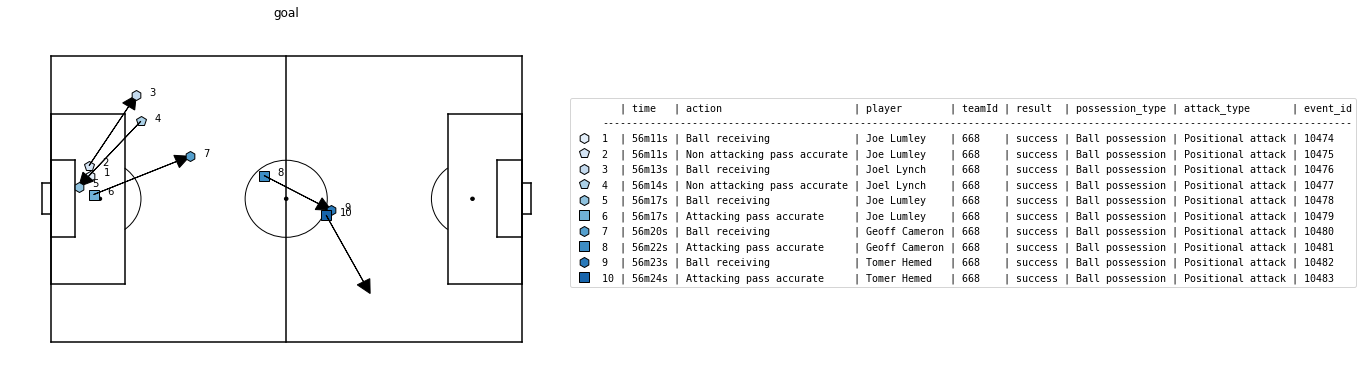

In [ ]:
dec = tfm.decode((x, y))
dec.show(figsize=10)

### Convert to `Tensor`s

The strategy here is to convert the processed `DataFrame` and target to a tuple of 3 tensors: one (`long`) for categorical features, one (`float`) for numerical features and one `TensorCategory` for the target.

In [ ]:
# export


def _convert_if_int(x):
    return int(x) if x == int(x) else float(x)


class FootSeqToTensor(ItemTransform):
    "Transform Tuple of pd.DataFrame and integer to appropriate tensors. Note that the first dimension is only useful for decoding"
    order = 10

    def __init__(
        self,
        cat_names,
        cont_names,
        labels,
        base_path,
        feats_first=True,
        max_len=None,
        meta_col="_id",
        sep="___",
    ):
        store_attr(but="labels")
        self.target_vocab, self.target_o2i = uniqueify(labels, sort=True, bidir=True)

    def encodes(self, x):
        ## keep metadata columns
        df, tgt = x

        ## reduce sequence length is needed
        if (self.max_len is not None) and (type(self.max_len) == int):
            df = df.tail(self.max_len)

        all_cols = df.columns.tolist()
        value_cols = self.cat_names + self.cont_names
        self.meta_cols = [col for col in all_cols if not col in value_cols]

        ## prepare info for metadata
        try:
            gm_id, poss_number, start_id, end_id, _ = (
                df[self.meta_col].values[0].split(self.sep)
            )
        except:
            set_trace()

        if self.feats_first:
            return (
                tensor(
                    [float(gm_id), float(poss_number), float(start_id), float(end_id)]
                ).float(),
                tensor(df[self.cat_names].values).long(),
                tensor(df[self.cont_names].values).float(),
                TensorCategory(tgt),
            )
        else:
            return (
                tensor(
                    [float(gm_id), float(poss_number), float(start_id), float(end_id)]
                ).float(),
                tensor(df[self.cat_names].values).long().transpose(1, 0),
                tensor(df[self.cont_names].values).float().transpose(1, 0),
                TensorCategory(tgt),
            )

    def decodes(self, x):
        meta, cats, conts, tgt = x
        if self.feats_first:
            cats_df = pd.DataFrame(cats.numpy(), columns=self.cat_names)
            conts_df = pd.DataFrame(conts.numpy(), columns=self.cont_names)
        else:
            cats_df = pd.DataFrame(cats.transpose(1, 0).numpy(), columns=self.cat_names)
            conts_df = pd.DataFrame(
                conts.transpose(1, 0).numpy(), columns=self.cont_names
            )

        ## retrieve meta
        tgt_name = self.target_vocab[tgt]
        meta_file_name = self.sep.join(str(_convert_if_int(x)) for x in meta.numpy())
        file_name = meta_file_name + self.sep + tgt_name + ".csv"
        file_path = self.base_path / file_name
        if not os.path.isfile(file_path):
            ## change target name
            tgt_name = np.delete(self.target_vocab, tgt)
            file_name = meta_file_name + self.sep + tgt_name[0] + ".csv"
            file_path = self.base_path / file_name

        meta_df = read_sequence_play(file_path)
        if (self.max_len is not None) and (type(self.max_len) == int):
            meta_df = meta_df.tail(self.max_len)

        df = pd.concat(
            [meta_df[self.meta_cols].reset_index(drop=True), cats_df, conts_df],
            axis="columns",
        ).reset_index(drop=True)

        return (df, tgt)

In [ ]:
## prepare some inputs
file_name = files_info[files_info.target == "goal"].sample(1)["file"].values[0]
x, y = tfm(file_name)

totsr = FootSeqToTensor(
    cat_names=cat_names,
    cont_names=cont_names,
    labels=labels,
    base_path=data_path,
    max_len=10,
)
totsr((x, y))

(tensor([1.4934e+06, 1.1700e+02, 2.0075e+04, 2.0092e+04]),
 tensor([[ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
         [ 5,  1,  1,  5,  1,  1,  9,  2,  3,  6,  2,  2],
         [ 5,  1,  1,  5,  1,  1, 26,  2, 12,  6,  2,  2],
         [ 5,  1,  1,  5,  1,  1,  9,  2,  3,  6,  2,  2],
         [ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
         [ 5,  1,  1,  5,  1,  1, 31,  2, 13,  6,  2,  2],
         [ 5,  1,  1,  5,  1,  1,  3,  2, 12,  5,  2,  2],
         [ 5,  1,  1,  5,  1,  1,  3,  2, 12,  5,  2,  2],
         [ 5,  2,  1,  5,  1,  1, 29,  2,  1,  6,  2,  2],
         [ 5,  2,  2,  5,  1,  1, 33,  2, 14,  5,  2,  2]]),
 tensor([[ 0.0206,  1.6379,  0.0931,  1.3211, -1.2659,  0.0464],
         [ 0.1681,  1.3140,  0.0931,  1.3211, -1.2643,  0.1382],
         [ 0.0037,  1.4608, -0.6796,  0.9272, -1.2629,  0.2164],
         [-0.6075,  0.9242, -0.6796,  0.9272, -1.2614,  0.3041],
         [-0.3588,  0.8331,  0.6307,  0.6151, -1.2596,  0.4055],
         [ 0.7077,  0.61

In [ ]:
tfms = Pipeline([tfm, totsr])
meta, cats, conts, y = tfms(file_name)

<AxesSubplot:title={'center':'goal'}>

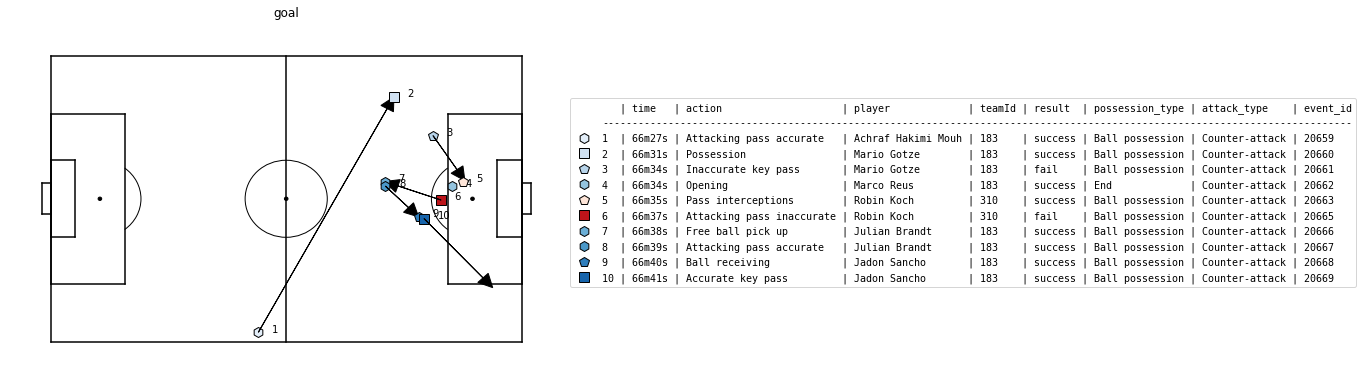

In [ ]:
tfms.show(tfms(file_name), figsize=10)

### `TfmdLists`

Now we are ready to create out `TfmdLists` objects by passing the `splits` and the raw inputs i.e the `ids`:

100% (2617 of 2617) |####################| Elapsed Time: 0:00:31 Time:  0:00:31


<AxesSubplot:title={'center':'no-goal'}>

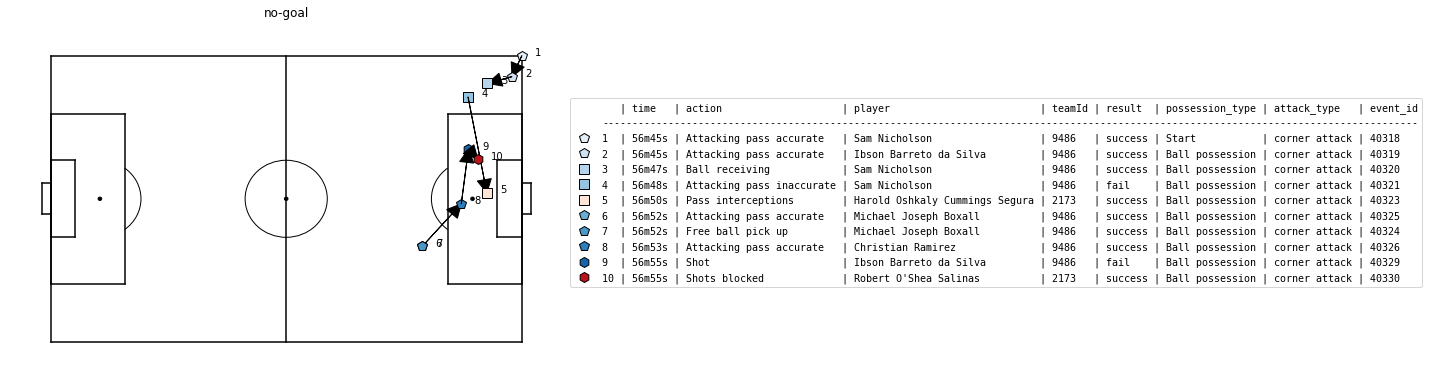

In [ ]:
tls = TfmdLists(train_val_files, [tfm, totsr], splits=splits_files)
show_at(tls.valid, 1, figsize=10)

## Batch

In this last section, we will investigate how batches are created. In particular, we will investigate few things:
+ *pad* short sequences with dummy values (usually 0) when needed
+ make the `show_batch()` work properly
* use `sortedDL` to minimize the amount of padding required

### Padding

Our playing sequences are by definition of different lengths. Similar to what we did for text, we need to pad our sequences to make sure they are all of the same length. 

The `pad_input()` was designed to do exactly that but does not quite work for 2D tensors. However, with minor changes we could adjust to our purposes:

In [ ]:
# export
class Pad_Seq(ItemTransform):
    def encodes(
        self, samples, pad_idx=0, pad_fields=[1, 2], pad_first=False, backwards=False
    ):
        "Function that collect `samples` and adds padding"
        self.pad_idx = pad_idx
        pad_fields = L(pad_fields)
        max_len_l = pad_fields.map(lambda f: max([len(s[f]) for s in samples]))
        if backwards:
            pad_first = not pad_first

        def _f(field_idx, x):
            if field_idx not in pad_fields:
                return x
            idx = pad_fields.items.index(
                field_idx
            )  # TODO: remove items if L.index is fixed
            sl = slice(-len(x), sys.maxsize) if pad_first else slice(0, len(x))
            pad = x.new_zeros((max_len_l[idx] - x.shape[0], x.shape[1])) + pad_idx
            x1 = torch.cat([pad, x] if pad_first else [x, pad], dim=0)
            if backwards:
                x1 = x1.flip(0)
            return retain_type(x1, x)

        return [tuple(map(lambda idxx: _f(*idxx), enumerate(s))) for s in samples]

    def decodes(self, t):
        pad_idx = self.pad_idx if hasattr(self, "pad_idx") else 1

        def _decode(o):
            def _f(tsr):
                return (tsr.shape[0] == 1) and (tsr.tolist()[0] == pad_idx)

            return o[np.where([not _f(torch.unique(t)) for t in torch.unbind(o)])]

        return (t[0], _decode(t[1]), _decode(t[2]), t[3])


pad_seq = Pad_Seq()

Let's first find some sequences with length shorter than 10: 

In [ ]:
short_file_ex = files_info[files_info.nSteps < 10].sample(5)["file"].tolist()

In [ ]:
fake_batch = [tfms(file) for file in short_file_ex]
x = pad_seq(fake_batch)
x[0]

(tensor([1.2357e+06, 1.3400e+02, 3.0812e+04, 3.0815e+04]),
 tensor([[ 5,  1,  4,  1,  1,  1, 31,  2, 13,  6,  2,  2],
         [ 5,  1,  1,  1,  1,  1,  3,  2, 12,  4,  2,  2],
         [ 5,  2,  1,  1,  1,  1, 29,  2,  1,  6,  2,  2],
         [ 5,  2,  2,  1,  1,  1, 33,  2, 14,  4,  2,  2],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[ 1.0491,  0.8787,  0.9708,  0.8811, -0.1002, -0.9284],
         [ 1.9554,  0.5598,  1.7435, -0.0193, -0.0973, -0.7646],
         [ 1.8163, -0.0274,  1.7351, -0.0347, -0.0972, -0.7584],
         [ 1.8247, -0.0122,  2.0039, -0.0142, -0.0956, -0.6659],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 TensorCategory(0))

In [ ]:
pad_seq.decode(x[0])

(tensor([1.2357e+06, 1.3400e+02, 3.0812e+04, 3.0815e+04]),
 tensor([[ 5,  1,  4,  1,  1,  1, 31,  2, 13,  6,  2,  2],
         [ 5,  1,  1,  1,  1,  1,  3,  2, 12,  4,  2,  2],
         [ 5,  2,  1,  1,  1,  1, 29,  2,  1,  6,  2,  2],
         [ 5,  2,  2,  1,  1,  1, 33,  2, 14,  4,  2,  2]]),
 tensor([[ 1.0491,  0.8787,  0.9708,  0.8811, -0.1002, -0.9284],
         [ 1.9554,  0.5598,  1.7435, -0.0193, -0.0973, -0.7646],
         [ 1.8163, -0.0274,  1.7351, -0.0347, -0.0972, -0.7584],
         [ 1.8247, -0.0122,  2.0039, -0.0142, -0.0956, -0.6659]]),
 TensorCategory(0))

### Dataloaders
Now we are ready to create our batch by a call to the `dataloaders()` method with the help of our *padding* `ItemTransform`:

In [ ]:
dls = tls.dataloaders(bs=3, before_batch=pad_seq)
b = dls.one_batch()
type(b)

tuple

### `show_batch()`

As we can see above, the batch produces a `tuple`. Perhaps, this is because we used `ItemTransform` instead of `Transform`. The hack here is to dispatch `show_batch()` over `tuple` and implement the appropriate functionality:

In [ ]:
@typedispatch
def show_batch(
    x: tuple,
    y,
    samples,
    ctxs=None,
    max_n=6,
    nrows=None,
    ncols=1,
    figsize=None,
    **kwargs
):
    n_elems = len(samples)
    if max_n > n_elems:
        max_n = n_elems
    if figsize is None:
        figsize = (10, 10 * 2.7)
    if ctxs is None:
        fig, ctxs = get_grid(
            max_n, nrows=None, ncols=ncols, figsize=figsize, return_fig=True
        )
    for i, ctx in enumerate(ctxs):
        samples[i].show(ctx=ctx, fig=fig)

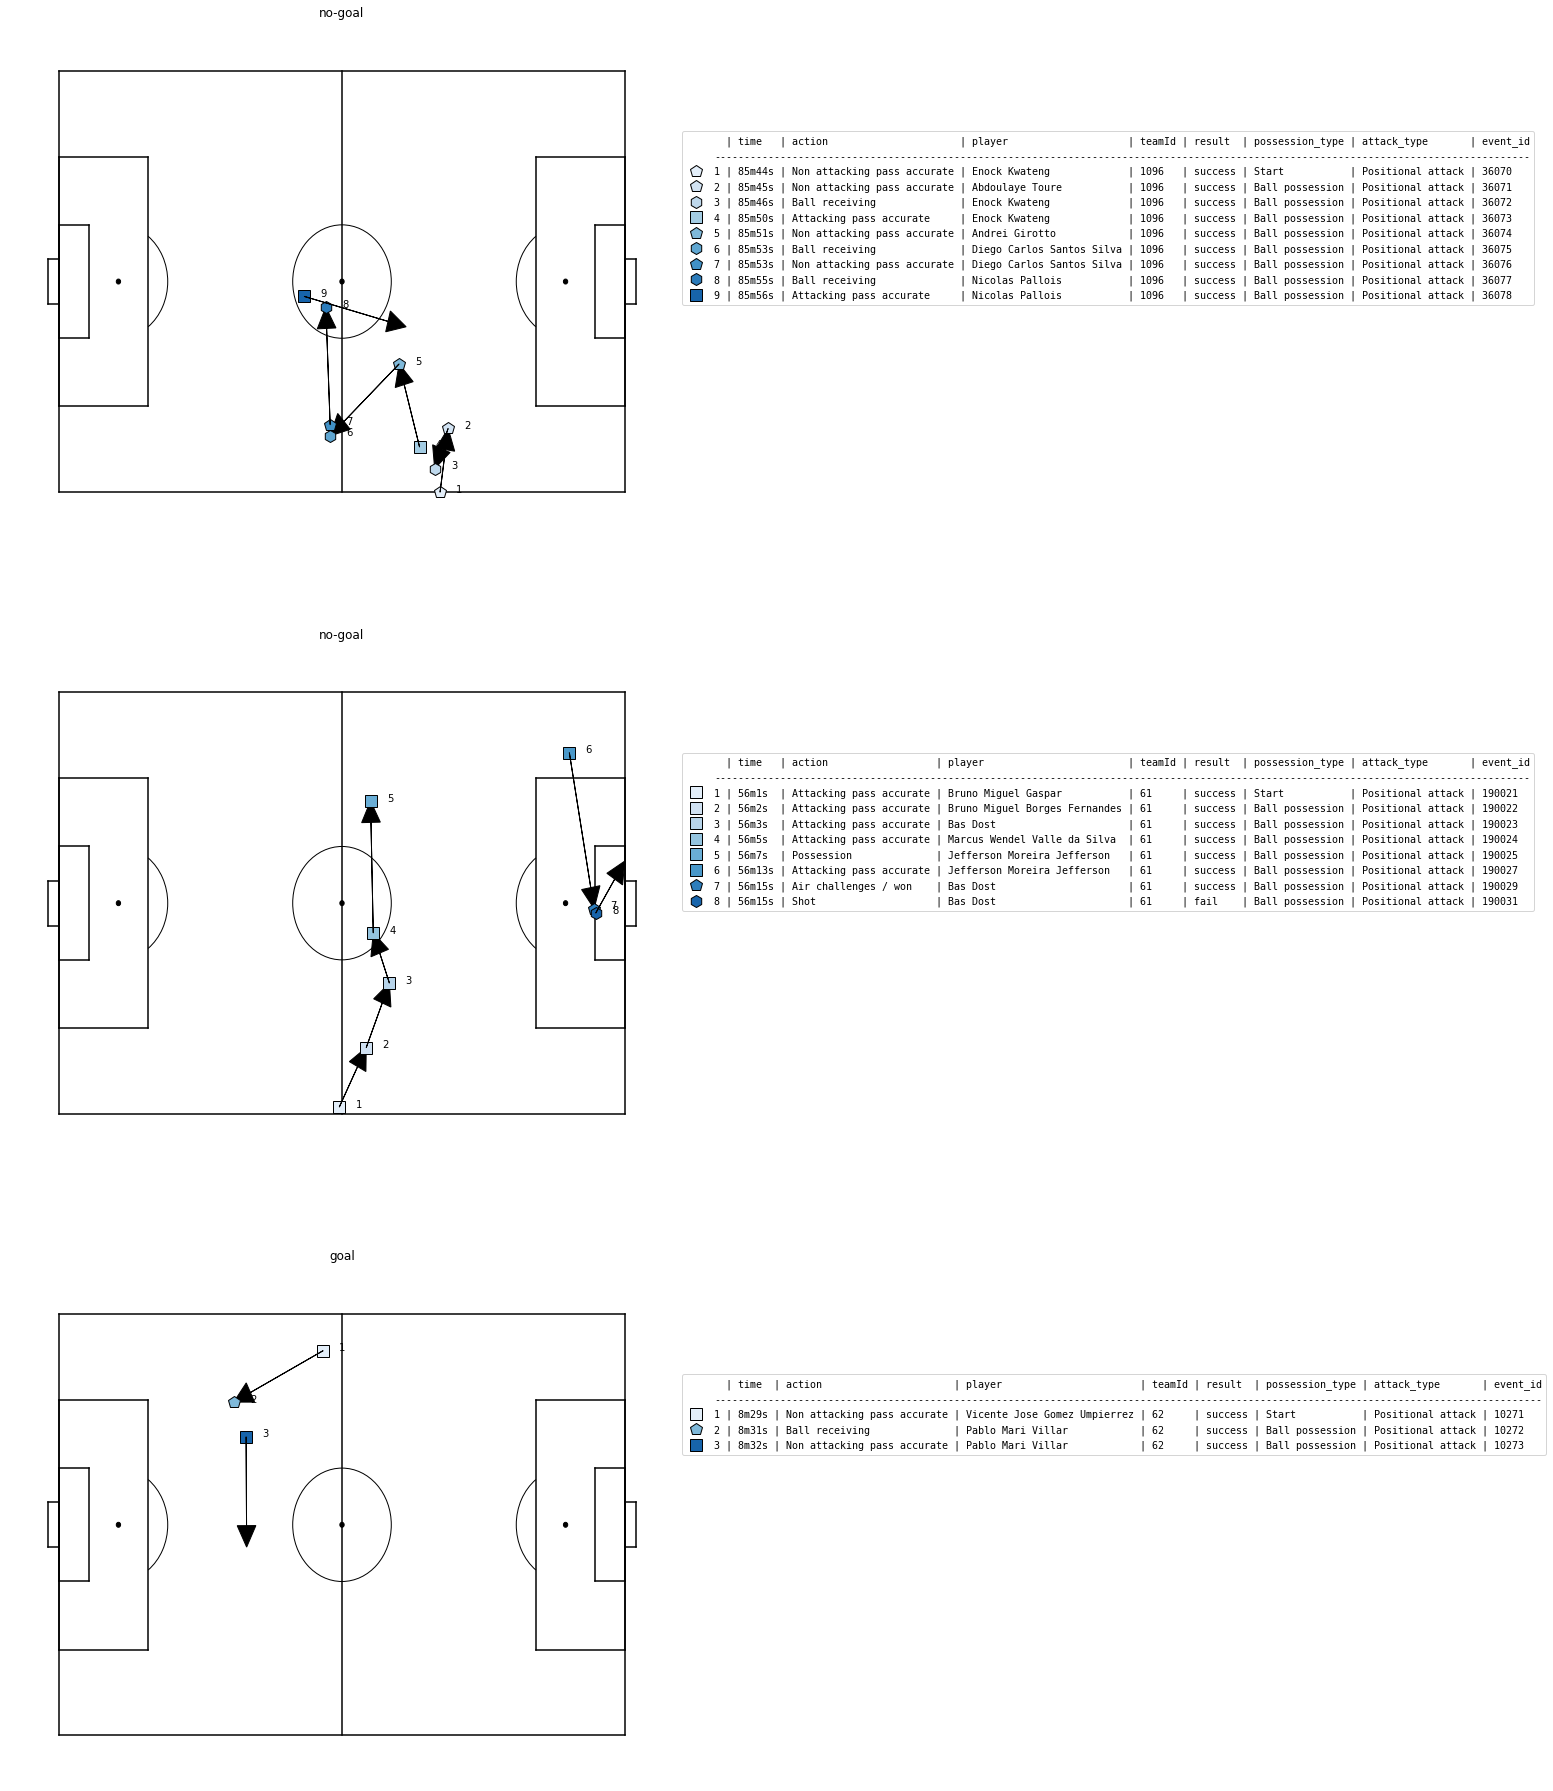

In [ ]:
base_fig_size = 12
dls.show_batch(figsize=(base_fig_size, base_fig_size * 2.7), ncols=1)

### Load data in specific order:`sortedDL`

In order to reduce the amount of padding when creating batches, it makes sense to load sequences with similar length together. In order to do that, we can sort our examples by their lengths and pass the information to our data-loader. That's what the `sortedDL` is for.

In order to speed up the `dataloaders` initialization, we pre-compute the length of the different sequences in the train and validation sets: 

In [ ]:
train_seq_lens = L(
    min(get_sequence_len(file), 10) for file in train_val_files[splits_files[0]]
)
valid_seq_lens = L(
    min(get_sequence_len(file), 10) for file in train_val_files[splits_files[1]]
)

In [ ]:
## pass the training dataset sequence lengths to SortedDL
srtd_dl = partial(SortedDL, res=train_seq_lens)

## Pass the validation dataset seq lengths
dl_kwargs = [{}, {"val_res": valid_seq_lens}]

## re-initialise dataloaders
srtd_dls = tls.dataloaders(
    bs=3, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)
srtd_batch = srtd_dls.one_batch()
srtd_batch

(tensor([[1.7210e+06, 3.4000e+01, 2.5423e+04, 2.5435e+04],
         [1.4940e+06, 7.4000e+01, 5.8200e+03, 5.8300e+03],
         [1.7093e+06, 4.5000e+01, 1.5624e+04, 1.5671e+04]]),
 tensor([[[ 5,  1,  1,  5,  1,  1,  9,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1, 10,  2,  4,  6,  1,  1],
          [ 5,  1,  1,  5,  1,  1, 16,  2,  8,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  2,  3,  6,  2,  2]],
 
         [[ 5,  1,  1,  5,  1,  1, 31,  2, 13,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1, 36,  2,  4,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  5,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,

As one can see, we didn't need padding for this batch as our `dataloaders` managed to find sequences of the same length.

# Summary

To summarize, we show here to create appropriate dataloaders for our football sequence data in a sequence code chunk:

In [ ]:
cat_names = [
    "standart_name",
    "possession_name",
    "attack_status_name",
    "attack_type_name",
    "under_pressure",
    "high_speed",
    "type_name",
    "result_name",
    "generic_action_type_name",
    "body_name",
    "is_poss_team",
    "is_att_team",
]
cont_names = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "time_seconds",
    "seconds_since_poss",
]

## params
no_goal_prop = 1.5
valid_pct = 0.3
seed = 43

train_val_files = L(files_info.file.tolist())

## splits
splits_files = goal_splitter(
    files_info_df=files_info, no_goal_prop=no_goal_prop, valid_pct=valid_pct, seed=seed
)

procs = [FillMissing, Categorify, Normalize]
foot_tfm = FootSeqTransform(
    files=train_val_files,
    splits=splits_files,
    labels=labels,
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
)


## to-tensor transform
to_tsr = FootSeqToTensor(
    cat_names=cat_names,
    cont_names=cont_names,
    labels=labels,
    base_path=data_path,
    max_len=10,
)

## tfmdlist
tls = TfmdLists(train_val_files, [foot_tfm, to_tsr], splits=splits_files)

## params for datalodaers
train_seq_lens = L(
    min(get_sequence_len(file), 10) for file in train_val_files[splits_files[0]]
)
valid_seq_lens = L(
    min(get_sequence_len(file), 10) for file in train_val_files[splits_files[1]]
)


## pass the training dataset sequence lengths to SortedDL
srtd_dl = partial(SortedDL, res=train_seq_lens)

## Pass the validation dataset seq lengths
dl_kwargs = [{}, {"val_res": valid_seq_lens}]

## re-initialise dataloaders
srtd_dls = tls.dataloaders(
    bs=3, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)
srtd_batch = srtd_dls.one_batch()

100% (2617 of 2617) |####################| Elapsed Time: 0:00:31 Time:  0:00:31
